### How to work with ERA5-Land on Earth Data Hub: storm Daniel flood, Greece 2023


***
[Earth Data Hub](https://earthdatahub.com) (EDH) offers an innovative and super-efficient way to access earth related data. This notebook will provide you guidance on how to access and use the [`https://data.earthdatahub.destine.eu/era5/reanalysis-era5-land-no-antartica-v0.zarr`](https://earthdatahub.com/collections/era5/datasets/reanalysis-era5-land) dataset on Earth Data Hub.


In order to access datasets on Earth Data Hub you need to instruct your tools (xarray, Zarr, etc.)  to use EDH personal access token when downloading the data.

To obtain a personal access token you first need to register to the [Destination Earth platform](https://platform.destine.eu). Then you can go to [Earth Data Hub account settings](https://earthdatahub.destine.eu/account-settings) where you can find your default personal access token or create others. After retrieving your personal access token, please cut and paste it below: &#x2935; 
***


In [1]:
PAT = 
# e.g. PAT=edh_pat_44bbb7e9192a4c6bb47ddf07d07564eee5d17de8dfc48f7118f88e3bc4a4157f8fe2403f5aa0a2d53441b6922ea9a33a

We will us it later when accessing the dataset.

### What you will learn:
* how to access and preview the dataset
* select and reduce the data
* plot the results
***

In this notebook we set two goals:

Our first goal is to compute the total precipitation observed during the Storm Daniel event, from 6 to 7 September 2023, in Greece, and compare it with the average 1991-2020 precipitation in the same area.

Our second goal is to compare the 2023 cumulative precipitation on a specific interland location (39.25 N, 21.9 E) with the cumulative 1991-2022 precipitation in the same location.


### Working with EDH data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data tipically looks like this:
1. data access and preview
2. data selection
3. (optional) data download 
4. (optional) data reduction
5. further operations and visualization

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place, e.g., when the `.compute()` or `.plot()` methods are called.

#### 1. Data access and preview
***
To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically when you access a Zarr dataset:

In [2]:
import xarray as xr

ds = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-land-no-antartica-v0.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
).astype("float32")
ds

<xarray.Dataset> Size: 687TB
Dimensions:              (valid_time: 648672, latitude: 1472, longitude: 3600)
Coordinates:
    depthBelowLandLayer  float32 4B ...
  * latitude             (latitude) float64 12kB 90.0 89.9 89.8 ... -57.0 -57.1
  * longitude            (longitude) float64 29kB 0.0 0.1 0.2 ... 359.8 359.9
    number               int64 8B ...
    surface              float64 8B ...
  * valid_time           (valid_time) datetime64[ns] 5MB 1950-01-01 ... 2023-...
Data variables: (12/50)
    asn                  (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    d2m                  (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    e                    (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    es                   (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    evabs                (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    evaow                (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    ...                   ...
    swvl4                (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    t2m                  (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tp                   (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tsn                  (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    u10                  (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    v10                  (valid_time, latitude, longitude) float32 14TB dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-06-12T09:14 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

⚠ At this point, no data has been downloaded yet, nor loaded in memory.

### Storm Daniel precipitation (6-7 September 2023) vs average September precipitation (1991-2022)

#### 2. Data selection

First, we perform a geographical selection corresponding to the Greece area:

In [3]:
tp = ds.tp
tp_greece = tp.sel(**{"latitude": slice(41, 34), "longitude": slice(19, 28)})
tp_greece

<xarray.DataArray 'tp' (valid_time: 648672, latitude: 70, longitude: 90)> Size: 16GB
dask.array<getitem, shape=(648672, 70, 90), dtype=float32, chunksize=(2880, 49, 64), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float32 4B ...
  * latitude             (latitude) float64 560B 40.9 40.8 40.7 ... 34.1 34.0
  * longitude            (longitude) float64 720B 19.0 19.1 19.2 ... 27.8 27.9
    number               int64 8B ...
    surface              float64 8B ...
  * valid_time           (valid_time) datetime64[ns] 5MB 1950-01-01 ... 2023-...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 648672
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

Second, we further select only two days: september 6 and 7, 2023. This greatly reduces the amount of data that will be downloaded from EDH.

In [4]:
tp_greece_storm_daniel = tp_greece.sel(valid_time=["2023-09-06", "2023-09-07"])
tp_greece_storm_daniel

<xarray.DataArray 'tp' (valid_time: 2, latitude: 70, longitude: 90)> Size: 50kB
dask.array<getitem, shape=(2, 70, 90), dtype=float32, chunksize=(2, 49, 64), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float32 4B ...
  * latitude             (latitude) float64 560B 40.9 40.8 40.7 ... 34.1 34.0
  * longitude            (longitude) float64 720B 19.0 19.1 19.2 ... 27.8 27.9
    number               int64 8B ...
    surface              float64 8B ...
  * valid_time           (valid_time) datetime64[ns] 16B 2023-09-06 2023-09-07
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 648672
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

#### 3. Data download

At this point, the selection is small enough to call `.compute()` on it, which will trigger the download of the data and load it in memory. 

We can measure the time it takes:

In [5]:
%time

tp_greece_storm_daniel = tp_greece_storm_daniel.compute()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


The data was very small. This didn't take long!

#### 4. Data reduction

Now that the data is loaded in memory, we can easily compute the total precipitation for the Storm Daniel event. We also convert the unit of measure to `mm`.

In [6]:
tp_greece_storm_daniel_sum = tp_greece_storm_daniel.sum("valid_time")
tp_greece_storm_daniel_sum
tp_greece_storm_daniel_sum = tp_greece_storm_daniel_sum * 1000
tp_greece_storm_daniel_sum.attrs["units"] = "mm"
tp_greece_storm_daniel_sum

<xarray.DataArray 'tp' (latitude: 70, longitude: 90)> Size: 25kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    depthBelowLandLayer  float32 4B 100.0
  * latitude             (latitude) float64 560B 40.9 40.8 40.7 ... 34.1 34.0
  * longitude            (longitude) float64 720B 19.0 19.1 19.2 ... 27.8 27.9
    number               int64 8B 0
    surface              float64 8B 0.0
Attributes:
    units:    mm

#### 5. Visualization
Finally, we can plot the Storm Daniel event on a map:

In [7]:
import display
from cartopy import crs

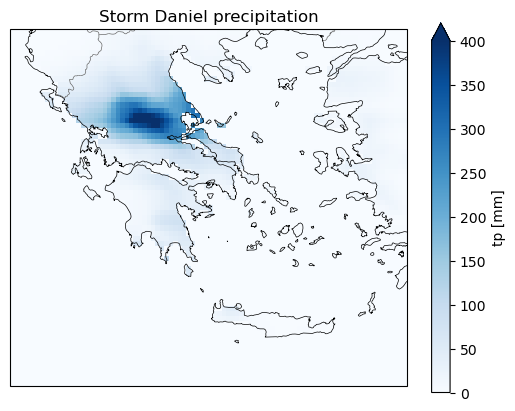

In [8]:
display.map(
    tp_greece_storm_daniel_sum, 
    projection=crs.Miller(), 
    vmax=400, 
    title="Storm Daniel precipitation"
);

We want to compare the total precipitation observed during Storm Daniel with the average precipitation observed in September between 1991 and 2020. 

The same considerations done before apply here. We will first select a subset of the dataset and then compute.

In [9]:
YEARS = [
    "1991", "1992", "1993",
    "1994", "1995", "1996",
    "1997", "1998", "1999",
    "2000", "2001", "2002",
    "2003", "2004", "2005",
    "2006", "2007", "2008",
    "2009", "2010", "2011",
    "2012", "2013", "2014",
    "2015", "2016", "2017",
    "2018", "2019", "2020",
]
DAYS = [
    "01", "02", "03",
    "04", "05", "06",
    "07", "08", "09",
    "10", "11", "12",
    "13", "14", "15",
    "16", "17", "18",
    "19", "20", "21",
    "22", "23", "24",
    "25", "26", "27",
    "28", "29", "30",
]

MONTH_REFERENCE_TIME = [f"{y}-09-{d}" for y in YEARS for d in DAYS]

tp_greece_september_1991_2020 = tp_greece.sel(valid_time=MONTH_REFERENCE_TIME)
tp_greece_september_1991_2020

<xarray.DataArray 'tp' (valid_time: 900, latitude: 70, longitude: 90)> Size: 23MB
dask.array<getitem, shape=(900, 70, 90), dtype=float32, chunksize=(30, 49, 64), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float32 4B ...
  * latitude             (latitude) float64 560B 40.9 40.8 40.7 ... 34.1 34.0
  * longitude            (longitude) float64 720B 19.0 19.1 19.2 ... 27.8 27.9
    number               int64 8B ...
    surface              float64 8B ...
  * valid_time           (valid_time) datetime64[ns] 7kB 1991-09-01 ... 2020-...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 648672
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

This is already small enough to call `.compute()` on it.

In [10]:
%time

tp_greece_september_1991_2020 = tp_greece_september_1991_2020.compute()

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


Now that the data is loaded in memory, we can easily compute the average september total precipitation for the years 1991-2020. We also convert the unit of measure to `mm`:

In [11]:
tp_greece_september_1991_2020_average = (tp_greece_september_1991_2020.sum("valid_time") / len(YEARS))
tp_greece_september_1991_2020_average
tp_greece_september_1991_2020_average = tp_greece_september_1991_2020_average * 1000
tp_greece_september_1991_2020_average.attrs["units"] = "mm"

Finally, we can plot the Storm Daniel event and the September 1991-2020 average side by side:

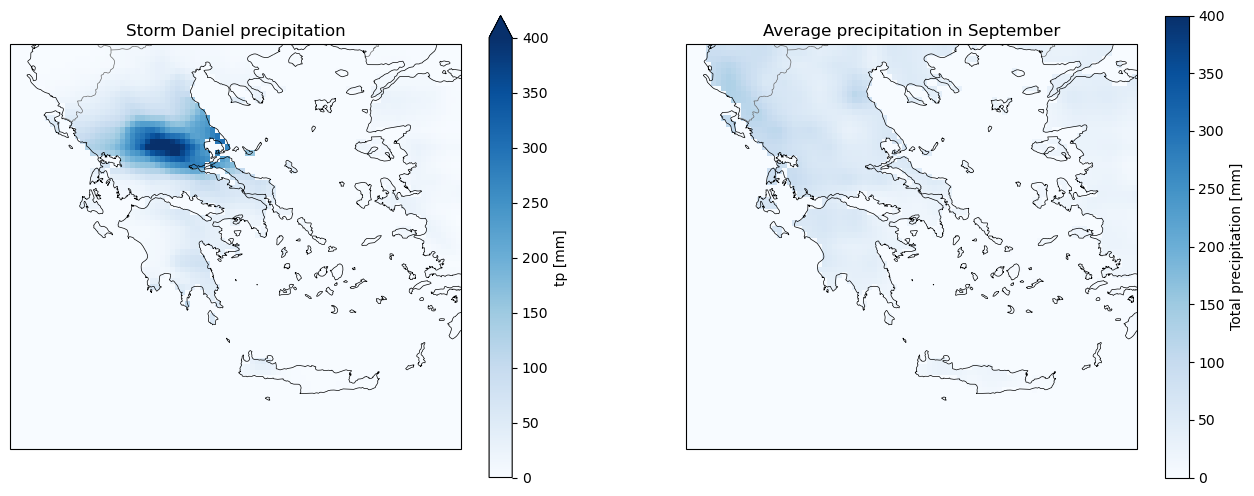

In [12]:
display.maps(
    [tp_greece_storm_daniel_sum, tp_greece_september_1991_2020_average],
    projection=crs.Miller(),
    vmax=400,
    axs_set=[
        {"title": "Storm Daniel precipitation"},
        {"title": "Average precipitation in September"},
    ],
)

### Cumulative precipitation: 2023 vs 1991-2022

In this section we will compare the 2023 cumulative precipitation on an interland location in Greece (39.25 N, 21.9 E), with the cumulative precipitation of each year between 1991 and 2020 in the same location. We will also highlight the 1991-2020 cumulative mean.

In [13]:
tp_hinterland_location = ds.tp.sel(**{"latitude": 39.25, "longitude": 21.9, "method": "nearest"})
tp_hinterland_location

<xarray.DataArray 'tp' (valid_time: 648672)> Size: 3MB
dask.array<getitem, shape=(648672,), dtype=float32, chunksize=(2880,), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float32 4B ...
    latitude             float64 8B 39.2
    longitude            float64 8B 21.9
    number               int64 8B ...
    surface              float64 8B ...
  * valid_time           (valid_time) datetime64[ns] 5MB 1950-01-01 ... 2023-...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 648672
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

This is already small enought to be computed:

In [14]:
%%time

tp_hinterland_location = tp_hinterland_location.compute()

CPU times: user 1min 28s, sys: 30.3 s, total: 1min 58s
Wall time: 10min 32s


With the data already loaded in memory, we can easily select the total daily precipitation (time 00:00) for each  day of the year:

In [15]:
import datetime
tp_hinterland_location_daily_total_2023 = tp_hinterland_location.sel(valid_time="2023").groupby("valid_time.time")[datetime.time()]
tp_hinterland_location_daily_total_1991_2022 = tp_hinterland_location.sel(valid_time=slice("1991", "2020")).groupby("valid_time.time")[datetime.time()]

Using the `display.compare()` method we can plot the cumulative precipitation for all the years between 1991 and 2022 (mean curve in red) and the cumulative precipitation for the year 2023 up to the 31 of October (blue curve)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


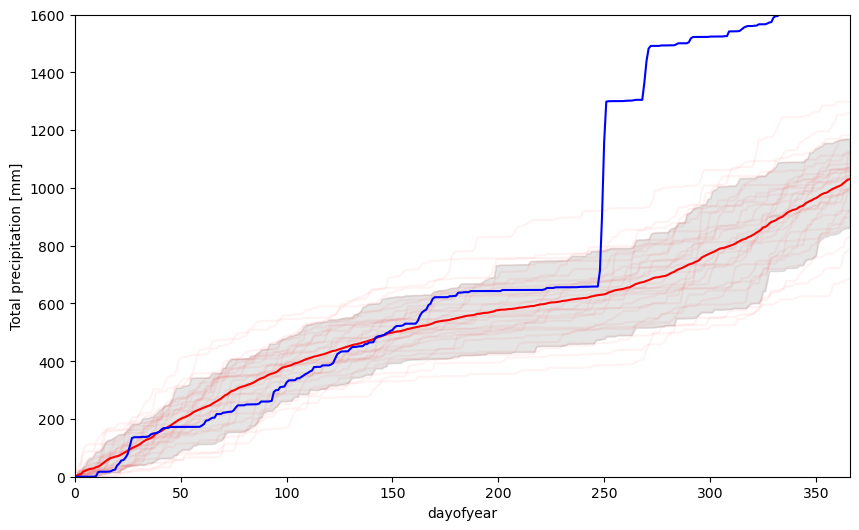

In [16]:
display.compare(
    tp_hinterland_location_daily_total_2023, 
    tp_hinterland_location_daily_total_1991_2022, 
    time="valid_time", 
    ylim=[0, 1600]
)